Prepared by: </br>&emsp;&emsp;Hufsa T &emsp;&emsp;Maria T &emsp;&emsp;HongGeun P

# Business Problem:
More and more businesses today are looking to recommendations systems to help them segment and target their customers with personalized products. We want to provide one solution to the question of what products a customer will buy, given the historical data we have about them.


# Data
Kaggle Dataset: Retail Recommendation Dataset (https://www.kaggle.com/retailrocket/ecommerce-dataset)

# Approach

We would like to explore the data using two different ML models to determine if we can predict, given a certain product, whether or not a customer will buy it.

We will be using two models, <b>XGBoost Classifier</b> and <b>RNN (LSTM)</b>, and will consider the following:
<ul>
    <li>What item did the user view?</li>
    <li>How many similar items did they view on the same day/historically? </li>
    <li>Did the user add the item to the cart? </li>
    <li>Does adding the item to cart result in a transaction?</li>
    <li>Did the user buy items in the same category before, and how many? (historical purchase count to be a feature)</li>
</ul>

<pre>The assumption was made that if a user views items under the same category, it is more likely the user will add those items to the cart and subsequently purchase the item. We verified this by plotting corelation between views and transaction events.</pre>

# Data Preparation

## Load the Modules

In [84]:
# Import basic libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import datetime
from datetime import timedelta
import os
import time
from pathlib import Path
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Import graphing libraries
import matplotlib as mlp
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import plotly
import plotly.graph_objects as go
from plotly.offline import plot
plotly.offline.init_notebook_mode(connected=True)

# Import sklearn libraries
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Filter convergence warnings
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings('ignore', category=ConvergenceWarning)

# Import XGB and others
import xgboost as xgb
from imblearn.over_sampling import SMOTE

# Import tensorflow
import tensorflow as tf
from tensorflow import keras

# TensorFlow ≥2.0 is required
assert tf.__version__ >= "2.0"

from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
%load_ext tensorboard

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
if IS_COLAB:
    print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


## Load and Clean Up Data

Our dataset comes in three different files: 
1. events file: contianing daily transaactions per customer and itemID
2. itemproperties file: contains attributes per itemID
3. category_tree file: contains the parentID of each categoryID an itemID belongs to  

The transformer below reads our data files and combines them together. We will **only be using the latest categoryID and parentID per each itemID** from item_properties file.  This transformer will also remove duplicate entries from the item_properties table.

In [30]:
# Creating a class to have an object that reads files and cleans the data and future access.
class Data(BaseEstimator, TransformerMixin):
    def __init__(self):
        # read files
        self.df_events = pd.read_csv('./ecommerce-dataset/events.csv')
        self.category = pd.read_csv('./ecommerce-dataset/category_tree.csv')
        self.item_property1 = pd.read_csv('./ecommerce-dataset/item_properties_part1.csv')
        self.item_property2 = pd.read_csv('./ecommerce-dataset/item_properties_part2.csv')
        
    def cleanData(self):
        # Use only rows that has value 'categoryid' in 'property' to link with category file
        item1 = self.item_property1[self.item_property1['property'] == 'categoryid']
        item2 = self.item_property2[self.item_property2['property'] == 'categoryid']

        ''' Clean item1,2 -> filter out only unique items with latest timestamp '''
        # rows without duplicates
        nodup = item1[item1.duplicated(['itemid'])==False]

        # Filter out duplicated rows with same itemid
        dup = item1[item1.duplicated(['itemid'])]
        dup = dup.sort_values(by=['itemid','timestamp'], ascending=False)
        clean = dup.drop_duplicates(['itemid'], keep='first')

        # add the data together
        item1 = nodup.append(clean)

        nodup = item2[item2.duplicated(['itemid'])==False]
        dup = item2[item2.duplicated(['itemid'])]
        dup = dup.sort_values(by=['itemid','timestamp'], ascending=False)

        # add the data together
        clean = dup.drop_duplicates(['itemid'], keep='first')

        item2 = nodup.append(clean)

        # concatenate item property files
        properties = pd.concat([item1,item2])

        # delete item1 and item2 as it is not needed anymore and to free up memory
        del item1, item2

        # excluding timestamp as it is not needed anymore
        properties.drop('timestamp', axis=1, inplace=True)

        # convert column 'value' to number
        properties['value'] = pd.to_numeric(properties['value'])

        # merge item and category
        cat_data = pd.merge(properties, self.category, left_on='value', right_on='categoryid')
        cat_data.drop(columns=['property', 'value'], inplace=True)
        cat_data['categoryid'] = cat_data['categoryid'].astype(str)
        cat_data['parentid'] = cat_data['parentid'].astype(str)

        # checking for null values
        cat_data.isnull().sum()

        # delete properties and category to free up memory
        del properties

        # how many unique vs repeat interactions with one order?
        print('unique transactions: ', self.df_events['transactionid'].dropna().unique().shape)
        print('total transactions', self.df_events['transactionid'].dropna().shape)

        # merge df_events and cat_data to create one dataset
        self.data = pd.merge(self.df_events, cat_data, how='left', on='itemid')
        
        # delete df_events and cat_data to free up memory
        del cat_data
   
    def fit(self):
        return self
    
    def transform(self):
        self.cleanData()
        return self.data

In [31]:
data = Data().transform()

unique transactions:  (17672,)
total transactions (22457,)


In [32]:
# Run a sample
print(data[data.itemid == 386527])

# Check for null values
null_columns=data.columns[data.isnull().any()]
data[null_columns].isnull().sum()

             timestamp  visitorid        event  itemid  transactionid  \
54       1433223148655     759369         view  386527            NaN   
441899   1434840979658     765630         view  386527            NaN   
474785   1435010995453      76757  transaction  386527           36.0   
482263   1435010914724      76757    addtocart  386527            NaN   
488705   1435010875183      76757         view  386527            NaN   
491739   1435010848906      76757         view  386527            NaN   
532062   1435184079851     765630         view  386527            NaN   
892618   1439335957923     661864         view  386527            NaN   
1193271  1440710698369    1134583         view  386527            NaN   
2589420  1436829733989    1301181         view  386527            NaN   
2617356  1436897152114    1313381         view  386527            NaN   

        categoryid parentid  
54             NaN      NaN  
441899         NaN      NaN  
474785         NaN      NaN  
482

transactionid    3034787
categoryid        255585
parentid          255585
dtype: int64

Now at this point, we should be splitting our data into train/test, but we can't. We need our final dataset to look like a daily level dataframe (with a record per itemID for every daily visit a user makes). We'll use this to predict if a user will convert on a daily visit. 

For that, we need a target column (with a conversion 0/1 value) but we don't have that yet. So we need to reshape our data first.

As well, our data relies on some features that are historical (e.g. previous purchases per user), so we need to create those from the entire dataset first, and then split it up. So we're going to start feature engineering here.

## Feature Engineering

Creating new features that will enable us to flatten data and train the model better. 

In [33]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer

# build transformer to select features
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, features):
        self.features_ = features
        
    def fit(self, X, y=None):
        pass
    
    def transform(self, X):
        return X[self.features_]

In [34]:
# build a transformer to handle date format change - needed to flaten the dataset to date level
class DateConverter(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        times = X.apply(lambda a: datetime.fromtimestamp(a//1000.0))
        return times

In [35]:
# build a transformer to create sessionid given a date and another column
class SessionCreator(BaseEstimator, TransformerMixin):
    def __init__(self, name):
        self.name = name
        
    def fit(self, X, y=None):
        pass
    
    def transform(self, X):
        col = X.columns.tolist()
        combined_col = X[col[0]].dt.date.astype(str) + '_' +  X[col[1]].astype(str)
        date = pd.to_datetime(X[col[0]].dt.date).rename('date')
        sess = combined_col.to_frame(self.name)
        return pd.concat([sess, date],axis=1)

In [36]:
# Check if the data is flattened
data['timestamp'] = DateConverter().fit_transform(data['timestamp'])
data.head()

,timestamp,visitorid,event,itemid,transactionid,categoryid,parentid
0,2015-06-02 01:02:12,257597,view,355908,NaN,1173,805.0
1,2015-06-02 01:50:14,992329,view,248676,NaN,1231,901.0
2,2015-06-02 01:13:19,111016,view,318965,NaN,NaN,NaN
3,2015-06-02 01:12:35,483717,view,253185,NaN,914,226.0
4,2015-06-02 01:02:17,951259,view,367447,NaN,1613,250.0


We've added a SessionCreator transformer to create a sessionID that is an identifier of a daily visit per user (regardless of how many itemIDs a user may have interacted with, every daily visit has one sessionID per date).

Now we can aggregate down to date level rather than datetime.

So we're now going to create the rest of the features that rely on historical data before we split into train/test.

First, let's look at the null values really quickly to see if we can handle for them now.

In [38]:
data.isnull().sum()

timestamp              0
visitorid              0
event                  0
itemid                 0
transactionid    3034787
categoryid        255585
parentid          255585
dtype: int64

In [39]:
# unique count of total itemIDs
data.itemid.shape

(3059355,)

In [40]:
# we could fill the missing values by computing the most frequent category...if we can without introducing bias.
data.categoryid.value_counts().head()

491     89944
1051    75216
1483    65871
959     52278
342     46852
Name: categoryid, dtype: int64

Here is the SessionID Feature

In [41]:
# Moving on, we'll create a sessionID variable that is only unique per day and not datetime, to flatten our dataset.
sess_level = make_pipeline(
    FeatureSelector(['timestamp', 'visitorid']), 
    SessionCreator('sessionid')
).transform(data)

# Create temporary variable so original data is not affected.
temp_data= pd.concat([data, sess_level], axis=1)
temp_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3059355 entries, 0 to 3059354
Data columns (total 9 columns):
 #   Column         Dtype         
---  ------         -----         
 0   timestamp      datetime64[ns]
 1   visitorid      int64         
 2   event          object        
 3   itemid         int64         
 4   transactionid  float64       
 5   categoryid     object        
 6   parentid       object        
 7   sessionid      object        
 8   date           datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(2), object(4)
memory usage: 233.4+ MB


### SessionID feature

We're aggregating down to daily level using sessionID.

In [42]:
session_agg = pd.pivot_table(temp_data, index=['sessionid','visitorid','date','itemid', 'categoryid','parentid' ],\
                             columns=['event'],values='timestamp',aggfunc='count', fill_value=0)
session_agg = session_agg.reset_index()
session_agg.head()

event,sessionid,visitorid,date,itemid,categoryid,parentid,addtocart,transaction,view
0,2015-05-02_1001994,1001994,2015-05-02,237081,1318,986.0,0,0,1
1,2015-05-02_1002147,1002147,2015-05-02,137032,1447,351.0,0,0,1
2,2015-05-02_1002397,1002397,2015-05-02,77392,337,653.0,0,0,1
3,2015-05-02_1004530,1004530,2015-05-02,116914,1120,250.0,0,0,1
4,2015-05-02_1004530,1004530,2015-05-02,116914,491,679.0,0,0,3


Make sure features will involve historical data that we cannot access if we're using a split dataset (e.g. a user's previous buying history).

### Previous Visits Feature

In [43]:
# a variable for number of previous visits by a user
visits = pd.pivot_table(temp_data, index=['sessionid', 'date','visitorid'], columns=['event'], values='itemid',aggfunc='count', fill_value=0)
visits = visits.reset_index()
visits['user_RN'] = visits.sort_values(['date'], ascending=[True]) \
             .groupby(['visitorid']) \
             .cumcount() + 1
visits.drop(columns=['addtocart', 'transaction', 'date', 'view', 'visitorid'], inplace=True)
visits.head()

event,sessionid,user_RN
0,2015-05-02_1001994,1
1,2015-05-02_1002147,1
2,2015-05-02_1002397,1
3,2015-05-02_1004530,1
4,2015-05-02_1006775,1


In [44]:
# merge with main dataset
session_agg = pd.merge(session_agg, visits, how="left", on=["sessionid"])

# sample
session_agg[session_agg['visitorid'] == 994820]

event,sessionid,visitorid,date,itemid,categoryid,parentid,addtocart,transaction,view,user_RN
1860737,2015-08-25_994820,994820,2015-08-25,301721,470,520.0,0,0,1,1
1860738,2015-08-25_994820,994820,2015-08-25,418795,396,164.0,0,0,2,1
1860739,2015-08-25_994820,994820,2015-08-25,418795,716,1056.0,0,0,2,1
1860740,2015-08-25_994820,994820,2015-08-25,439963,793,1066.0,0,0,1,1
1860741,2015-08-25_994820,994820,2015-08-25,456276,396,164.0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...
2184042,2015-09-17_994820,994820,2015-09-17,296592,992,1008.0,0,0,1,16
2184043,2015-09-17_994820,994820,2015-09-17,64529,1431,1066.0,0,0,1,16
2184044,2015-09-17_994820,994820,2015-09-17,255334,260,1066.0,0,0,1,16
2184045,2015-09-17_994820,994820,2015-09-17,213213,352,859.0,0,0,1,16


### Previous Purchases Count by Visitor

In [45]:
# now count how many purchases they've had on our site prior to each visit.

# group by session
purchases = pd.pivot_table(temp_data, index=['sessionid', 'date','visitorid'], columns=['event'], values='itemid',aggfunc='count', fill_value=0)
purchases = purchases.reset_index()
purchases['purchases_to_date'] = purchases.sort_values(['date'], ascending=[True]) \
             .groupby(['visitorid'])['transaction'].cumsum()

# grab prev purchases since we won't know if a user is about to make a purchase currently
purchases['historical_purchases'] = purchases.groupby(['visitorid'])['purchases_to_date'].shift(1)
purchases['historical_purchases'].fillna(0, inplace=True)

# drop everything we don't need
purchases.drop(columns=['date', 'visitorid', 'transaction', 'addtocart', 'view', 'purchases_to_date'], inplace=True)

purchases.head()

event,sessionid,historical_purchases
0,2015-05-02_1001994,0.0
1,2015-05-02_1002147,0.0
2,2015-05-02_1002397,0.0
3,2015-05-02_1004530,0.0
4,2015-05-02_1006775,0.0


In [46]:
# Now add purchases to the data
session_agg = pd.merge(session_agg, purchases, how="left", on=["sessionid"])
session_agg['historical_purchases'].fillna(0, inplace=True)

# sample
session_agg[session_agg['visitorid'] == 599528]

event,sessionid,visitorid,date,itemid,categoryid,parentid,addtocart,transaction,view,user_RN,historical_purchases
502047,2015-06-02_599528,599528,2015-06-02,356475,386,1095.0,1,1,2,1,0.0
568571,2015-06-06_599528,599528,2015-06-06,356475,386,1095.0,0,0,1,2,1.0
581513,2015-06-07_599528,599528,2015-06-07,356475,386,1095.0,0,0,1,3,1.0
615422,2015-06-09_599528,599528,2015-06-09,356475,386,1095.0,0,0,2,4,1.0
634227,2015-06-10_599528,599528,2015-06-10,356475,386,1095.0,0,0,4,5,1.0
650753,2015-06-11_599528,599528,2015-06-11,356475,386,1095.0,0,0,2,6,1.0
663664,2015-06-12_599528,599528,2015-06-12,356475,386,1095.0,0,0,2,7,1.0
1855827,2015-08-25_599528,599528,2015-08-25,64279,1213,955.0,0,0,1,8,1.0


### Previous Visits Count Feature

In [47]:
# create feature for how many previous visits user has had.
session_agg['previous_visits'] = session_agg['user_RN'] -1

# now get historical views of the item prior to the visit
item_views = pd.pivot_table(temp_data, index=['sessionid','visitorid','date','itemid'], columns=['event'],values='timestamp',aggfunc='count', fill_value=0)
item_views = item_views.reset_index()
item_views.drop(columns=['addtocart','transaction'], inplace=True)
item_views['total_views'] = item_views.sort_values(['date'], ascending=[True])\
                                .groupby(['visitorid','itemid'])['view'].cumsum()
item_views['prev_item_views']  = item_views.groupby(['visitorid','itemid'])['total_views'].shift(1)
item_views.fillna(0, inplace=True)
item_views.drop(columns=['visitorid','date','view','total_views'], inplace=True)
item_views.head()

# merge into the data
session_agg = pd.merge(session_agg, item_views, how="left", on=["sessionid","itemid"])

# sample
session_agg[session_agg['visitorid'] == 599528]

event,sessionid,visitorid,date,itemid,categoryid,parentid,addtocart,transaction,view,user_RN,historical_purchases,previous_visits,prev_item_views
502047,2015-06-02_599528,599528,2015-06-02,356475,386,1095.0,1,1,2,1,0.0,0,0.0
568571,2015-06-06_599528,599528,2015-06-06,356475,386,1095.0,0,0,1,2,1.0,1,2.0
581513,2015-06-07_599528,599528,2015-06-07,356475,386,1095.0,0,0,1,3,1.0,2,3.0
615422,2015-06-09_599528,599528,2015-06-09,356475,386,1095.0,0,0,2,4,1.0,3,4.0
634227,2015-06-10_599528,599528,2015-06-10,356475,386,1095.0,0,0,4,5,1.0,4,6.0
650753,2015-06-11_599528,599528,2015-06-11,356475,386,1095.0,0,0,2,6,1.0,5,10.0
663664,2015-06-12_599528,599528,2015-06-12,356475,386,1095.0,0,0,2,7,1.0,6,12.0
1855827,2015-08-25_599528,599528,2015-08-25,64279,1213,955.0,0,0,1,8,1.0,7,0.0


### Feature to show No. of Days since previous visit by user

In [23]:
#New Feature to count number of days since last visit for each visitor - this takes a while to run
timec =  pd.pivot_table(temp_data, index=['sessionid','visitorid','date'], columns=['event'],values='timestamp',aggfunc='count', fill_value=0)
timec = timec.reset_index()
timec.drop(columns=['addtocart','transaction','view'], inplace=True)
timec = timec.sort_values(['date'], ascending=[True])
timec.head()

event,sessionid,visitorid,date
0,2015-05-02_1001994,1001994,2015-05-02
416,2015-05-02_54791,54791,2015-05-02
417,2015-05-02_551864,551864,2015-05-02
418,2015-05-02_554308,554308,2015-05-02
419,2015-05-02_560305,560305,2015-05-02


In [24]:
from datetime import timedelta
timec['DaysSinceLastVisit'] = timec.groupby(['visitorid'])['date'].diff()
timec.fillna(timedelta(0), inplace=True)
timec.head()

event,sessionid,visitorid,date,DaysSinceLastVisit
0,2015-05-02_1001994,1001994,2015-05-02,0 days
416,2015-05-02_54791,54791,2015-05-02,0 days
417,2015-05-02_551864,551864,2015-05-02,0 days
418,2015-05-02_554308,554308,2015-05-02,0 days
419,2015-05-02_560305,560305,2015-05-02,0 days


In [25]:
timec.drop(columns=['date'], inplace=True)

# merge into the data
session_agg = pd.merge(session_agg, timec, how="left", on=["sessionid","visitorid"])

# sample
session_agg[session_agg['visitorid'] == 599528]

event,sessionid,visitorid,date,itemid,categoryid,parentid,addtocart,transaction,view,user_RN,historical_purchases,previous_visits,prev_item_views,DaysSinceLastVisit
502047,2015-06-02_599528,599528,2015-06-02,356475,386,1095.0,1,1,2,1,0.0,0,0.0,0 days
568571,2015-06-06_599528,599528,2015-06-06,356475,386,1095.0,0,0,1,2,1.0,1,2.0,4 days
581513,2015-06-07_599528,599528,2015-06-07,356475,386,1095.0,0,0,1,3,1.0,2,3.0,1 days
615422,2015-06-09_599528,599528,2015-06-09,356475,386,1095.0,0,0,2,4,1.0,3,4.0,2 days
634227,2015-06-10_599528,599528,2015-06-10,356475,386,1095.0,0,0,4,5,1.0,4,6.0,1 days
650753,2015-06-11_599528,599528,2015-06-11,356475,386,1095.0,0,0,2,6,1.0,5,10.0,1 days
663664,2015-06-12_599528,599528,2015-06-12,356475,386,1095.0,0,0,2,7,1.0,6,12.0,1 days
1855827,2015-08-25_599528,599528,2015-08-25,64279,1213,955.0,0,0,1,8,1.0,7,0.0,74 days


In [26]:
# Another feature to add

session_agg['converted'] = np.where(session_agg['transaction'] > 0,1,0)

# do some cleanup of the df as well.
session_agg['historical_purchases'] = session_agg['historical_purchases'].astype(int)
session_agg['prev_item_views'] = session_agg['prev_item_views'].astype(int)
session_agg['DaysSinceLastVisit'] = session_agg['DaysSinceLastVisit'].dt.days

# drop unnecessary columns
# we're dropping transaction because it is our new conversion column
session_agg.drop(columns=['sessionid','visitorid','itemid','transaction','user_RN'], inplace=True)
session_agg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2184095 entries, 0 to 2184094
Data columns (total 10 columns):
date                    datetime64[ns]
categoryid              object
parentid                object
addtocart               int64
view                    int64
historical_purchases    int32
previous_visits         int64
prev_item_views         int32
DaysSinceLastVisit      int64
converted               int32
dtypes: datetime64[ns](1), int32(3), int64(4), object(2)
memory usage: 158.3+ MB


In [27]:
# strip out the '.0' in parentid column
session_agg['parentid']= session_agg['parentid'].apply(lambda x: x[:-2])
session_agg.head()

event,date,categoryid,parentid,addtocart,view,historical_purchases,previous_visits,prev_item_views,DaysSinceLastVisit,converted
0,2015-05-02,1318,986,0,1,0,0,0,0,0
1,2015-05-02,1447,351,0,1,0,0,0,0,0
2,2015-05-02,337,653,0,1,0,0,0,0,0
3,2015-05-02,1120,250,0,1,0,0,0,0,0
4,2015-05-02,491,679,0,3,0,0,0,0,0


In [80]:
session_agg.shape

(2184095, 10)

### Create target variable

In [49]:
session_agg['converted'] = np.where(session_agg['transaction'] > 0,1,0)

# do some cleanup of the df as well.
session_agg['historical_purchases'] = session_agg['historical_purchases'].astype(int)
session_agg['prev_item_views'] = session_agg['prev_item_views'].astype(int)

# drop unnecessary columns
# we're dropping transaction because it is our new conversion column
session_agg.drop(columns=['sessionid','visitorid','itemid','transaction','user_RN'], inplace=True)
session_agg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2184095 entries, 0 to 2184094
Data columns (total 9 columns):
 #   Column                Dtype         
---  ------                -----         
 0   date                  datetime64[ns]
 1   categoryid            object        
 2   parentid              object        
 3   addtocart             int64         
 4   view                  int64         
 5   historical_purchases  int32         
 6   previous_visits       int64         
 7   prev_item_views       int32         
 8   converted             int32         
dtypes: datetime64[ns](1), int32(3), int64(3), object(2)
memory usage: 141.6+ MB


In [50]:
# strip out the '.0' in parentid column
session_agg['parentid']= session_agg['parentid'].apply(lambda x: x[:-2])
session_agg.head()

event,date,categoryid,parentid,addtocart,view,historical_purchases,previous_visits,prev_item_views,converted
0,2015-05-02,1318,986,0,1,0,0,0,0
1,2015-05-02,1447,351,0,1,0,0,0,0
2,2015-05-02,337,653,0,1,0,0,0,0
3,2015-05-02,1120,250,0,1,0,0,0,0
4,2015-05-02,491,679,0,3,0,0,0,0


# Data Exploration and Creating Train/Test Set

## Split into Train/Test

In [51]:
# Create a copy
x = session_agg.copy()

In [52]:
# Split into train and test sets
y = x['converted']
x.drop('converted', axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

print('train: ', X_train.shape)
print('test ', X_test.shape)

train:  (1747276, 8)
test  (436819, 8)


## Analyzing and feature-engineering training data

In [53]:
# first make a copy of training data to play around with
df = pd.concat([X_train, y_train], axis=1)
df.head()

,date,categoryid,parentid,addtocart,view,historical_purchases,previous_visits,prev_item_views,converted
654241,2015-06-11,1011,745,0,1,0,0,0,0
1764202,2015-08-19,1228,121,0,1,0,0,0,0
770499,2015-06-19,1120,250,0,1,0,0,0,0
2171509,2015-09-16,1318,986,0,1,0,0,0,0
1907508,2015-08-29,242,1531,0,1,0,0,0,0


We're adding another feature only to the training data first - a weekday column to utilize the date. We might see weekly patterns.

In [54]:
# build a transformer to handle date - parsing date
class WeekdayExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        weekday = X.apply(lambda x: x.weekday())
        return weekday.rename('weekday').to_frame()

In [55]:
# Pipeline to transform date
wkday = make_pipeline(
    FeatureSelector('date'), 
    WeekdayExtractor()
).transform(df)

df = pd.concat([df, wkday], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1747276 entries, 654241 to 1692743
Data columns (total 10 columns):
 #   Column                Dtype         
---  ------                -----         
 0   date                  datetime64[ns]
 1   categoryid            object        
 2   parentid              object        
 3   addtocart             int64         
 4   view                  int64         
 5   historical_purchases  int32         
 6   previous_visits       int64         
 7   prev_item_views       int32         
 8   converted             int32         
 9   weekday               int64         
dtypes: datetime64[ns](1), int32(3), int64(4), object(2)
memory usage: 126.6+ MB


1    231385
4     61961
3     35877
2     27879
Name: previous_visits, dtype: int64

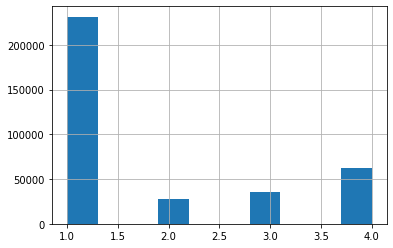

In [56]:
# numbers of previous visits
df_pvisits = pd.cut(df['previous_visits'],bins=[0,2,3,6, np.inf], labels=[1,2,3,4])
df_pvisits.hist()
df_pvisits.value_counts()

1    59694
4    16594
2    16007
3     6107
Name: prev_item_views, dtype: int64

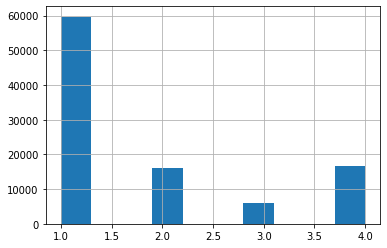

In [57]:
# numbers of previous item views
df_view = pd.cut(df['prev_item_views'],bins=[0,2,4,6, np.inf], labels=[1,2,3,4])
df_view.hist()
df_view.value_counts()

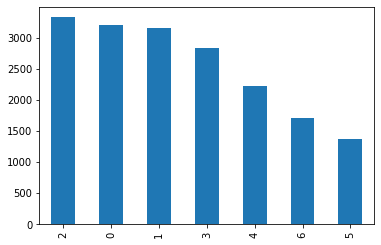

In [58]:
# what weekdays do conversions mostly happen on?
df.query(' converted == 1 ')['weekday'].value_counts().plot(kind='bar')

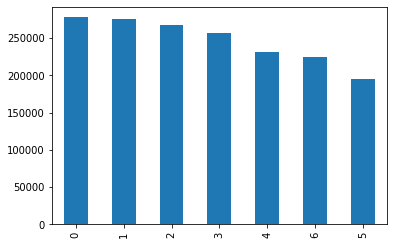

In [59]:
# what weekdays have less conversion?
df.query(' converted == 0 ')['weekday'].value_counts().plot(kind='bar')

In [60]:
weekdays = pd.get_dummies(df['weekday'], prefix='weekday_', drop_first=True)
df = pd.concat([df,weekdays],axis=1)
df.drop('weekday', axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1747276 entries, 654241 to 1692743
Data columns (total 15 columns):
 #   Column                Dtype         
---  ------                -----         
 0   date                  datetime64[ns]
 1   categoryid            object        
 2   parentid              object        
 3   addtocart             int64         
 4   view                  int64         
 5   historical_purchases  int32         
 6   previous_visits       int64         
 7   prev_item_views       int32         
 8   converted             int32         
 9   weekday__1            uint8         
 10  weekday__2            uint8         
 11  weekday__3            uint8         
 12  weekday__4            uint8         
 13  weekday__5            uint8         
 14  weekday__6            uint8         
dtypes: datetime64[ns](1), int32(3), int64(3), object(2), uint8(6)
memory usage: 123.3+ MB


Plotting correlation of our dataset to identify important features.

In [61]:
corrmap = df.corr(method='pearson')
corrmap.reset_index()
corrmap['converted'].sort_values(ascending=False)

converted               1.000000
addtocart               0.423663
historical_purchases    0.100676
view                    0.083823
previous_visits         0.047193
weekday__2              0.008793
weekday__1              0.004775
prev_item_views         0.003071
weekday__3              0.003004
weekday__4             -0.002723
weekday__6             -0.010206
weekday__5             -0.011285
Name: converted, dtype: float64

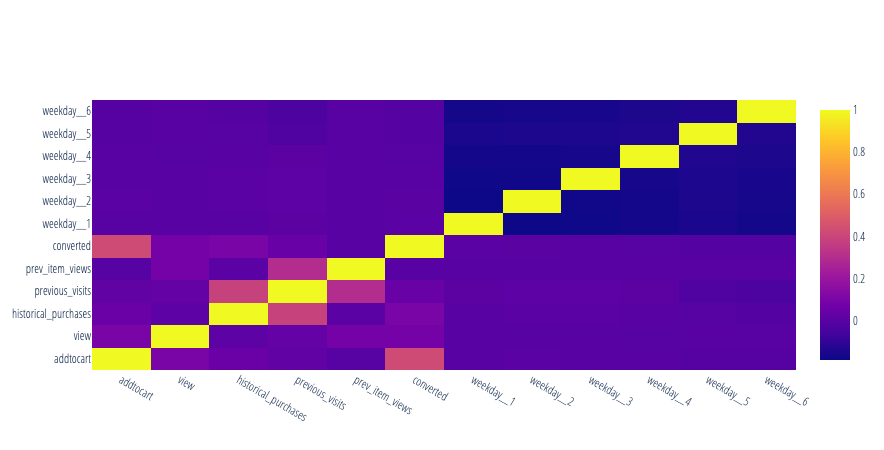

In [62]:
def df_to_plotly(df):
    return {'z': df.values.tolist(),
            'x': df.columns.tolist(),
            'y': df.index.tolist()}

fig = go.Figure(data=go.Heatmap(df_to_plotly(corrmap)))
fig.show()

# Training Different Models

We're testing a couple of basic models (LogisticRegression and RandomForest) to get a baseline performance value of our dataset.

In [63]:
# pipeline to extract weekday
wkday_pipeline = make_pipeline(
    WeekdayExtractor(), OneHotEncoder())

# bring in simpleimputer in case we ever have a case of missing numeric data.
num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

# log_pipeline = make_pipeline(FunctionTransformer(np.log1p, validate=True))
num_attribs = list(X_train.select_dtypes(include=[np.number]))
cat_attribs = list(X_train.select_dtypes(include=object))

full_pipeline = ColumnTransformer([
        ("wkday", wkday_pipeline, 'date'),
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs)
    ])

In [64]:
df_prepared = full_pipeline.fit_transform(X_train)
df_prepared.shape

(1747276, 1452)

## Model Trial 1: Logistic Regression

The first model we tried was a logistic regression. The logisitc regression did not preform very well. It yielded the following values: <br/> 
Precision:  0.382<br/> 
Recall:  0.11<br/> 
F1 Score:  0.17<br/>

In [65]:
model = LogisticRegression(n_jobs=-1, max_iter=1000)
model.fit(df_prepared, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [66]:
# predict model
y_train_pred = cross_val_predict(model, df_prepared, y_train, cv=5, verbose=2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  8.7min finished


In [68]:
print('Precision: ', precision_score(y_train, y_train_pred))
print('Recall: ', recall_score(y_train, y_train_pred))
print('F1 Score: ', f1_score(y_train, y_train_pred))

Precision:  0.3816779170684667
Recall:  0.11092427554509277
F1 Score:  0.17189264309910535


In [69]:
# confusion matrix
cm = confusion_matrix(y_train, y_train_pred, labels=[0,1])
pd.DataFrame(cm)

,0,1
0,1726229,3206
1,15862,1979


## Model Trial 2: Random Forest

Random Forest does not perform very well either, it has the following values:  <br/> 
Precision:  0.59 <br/> 
Recall:  0.35  <br/> 
F1 Score:  0.44 <br/> 

In [83]:
rf_model = RandomForestClassifier()
rf_model.fit(df_prepared, y_train)

y_train_pred = cross_val_predict(rf_model, df_prepared, y_train, cv=5, verbose=2)

print('RandomForestClassifier:')
print('Precision: ', precision_score(y_train, y_train_pred))
print('Recall: ', recall_score(y_train, y_train_pred))
print('F1 Score: ', f1_score(y_train, y_train_pred))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 48.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 236.4min finished


RandomForestClassifier:
Precision:  0.5930916682482444
Recall:  0.3503166862844011
F1 Score:  0.4404665421614575


## Model Trial 3: XG Boost

Now we try our intended model, XGB, with some hyperparameter tuning.

### XGBoost Baseline

In [44]:
#XGB Baseline will allow us to see how a model with no hypertuning will preform on our original dataset
model=xgb.XGBClassifier(random_state=1,learning_rate=0.01)
model.fit(df_prepared, y_train)
y_train_pred = cross_val_predict(model, df_prepared, y_train, cv=5, verbose=2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  8.1min finished


In [45]:
print ('Accuracy: ', accuracy_score(y_train, y_train_pred))
print('Precision: ', precision_score(y_train, y_train_pred))
print('Recall: ', recall_score(y_train, y_train_pred))
print('F1 Score: ', f1_score(y_train, y_train_pred))

Accuracy:  0.991759744882892
Precision:  0.7862963578912356
Recall:  0.26500756684042376
F1 Score:  0.3964115033118136


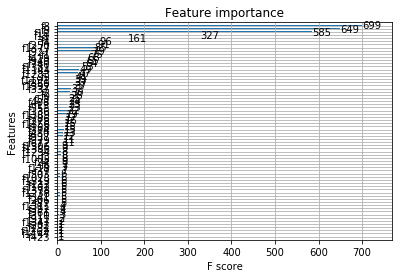

In [73]:
# Feature Importance Test
xgb.plot_importance(model)
plt.rcParams['figure.figsize'] = [30, 30]
plt.show()

The baseline XGB gives us results that are not too terrible, however we will try to do some hypertuning to improve this because recall and f1 are very low. 
Accuracy:  0.99<br/>
Precision:  0.79<br/>
Recall:  0.27<br/>
F1 Score:  0.396

### Resampling the data

We seem to have imbalanced data in our training set where 96% of the datapoints have no conversion. Lets try resampling the data to see if this improves our results

### Random Undersampling

In [190]:
df_resample = pd.concat([X_train, y_train], axis=1)
df_resample.shape

(1747276, 10)

Class 0: 1729435
Class 1: 17841
Proportion: 96.94 : 1


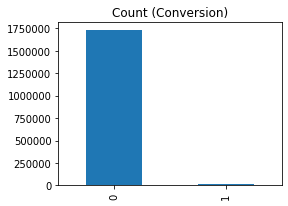

In [191]:
plt.figure(figsize=(4,3))
conversion_count = df_resample.converted.value_counts()
print('Class 0:', conversion_count[0])
print('Class 1:', conversion_count[1])
print('Proportion:', round(conversion_count[0] / conversion_count[1], 2), ': 1')

conversion_count.plot(kind='bar', title='Count (Conversion)')

In [194]:
count_class_0, count_class_1 = df_resample.converted.value_counts()
# Divide by class
df_class_0 = df_resample[df_resample['converted'] == 0]
df_class_1 = df_resample[df_resample['converted'] == 1]

Random under-sampling:
1    17841
0    17841
Name: converted, dtype: int64


,date,categoryid,parentid,addtocart,view,historical_purchases,previous_visits,prev_item_views,DaysSinceLastVisit,converted
1877054,2015-08-27,1580,441,0,1,0,0,0,0,0
105851,2015-05-09,406,872,0,1,0,0,0,0,0
2032986,2015-09-07,452,561,0,1,0,1,0,97,0
826576,2015-06-23,491,679,0,1,0,0,0,0,0
1077378,2015-07-08,1625,1141,0,1,0,0,0,0,0


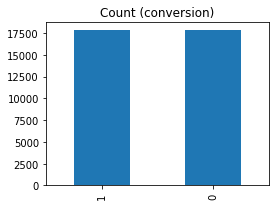

In [195]:
plt.figure(figsize=(4,3))
df_class_0_under = df_class_0.sample(count_class_1)
df_resample = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_resample.converted.value_counts())

df_resample.converted.value_counts().plot(kind='bar', title='Count (conversion)');

df_resample.head()

In [196]:
#split x and y again 
y__train_resampled = df_resample['converted']
df_resample.drop('converted', axis=1, inplace=True)

In [198]:
# put x_train through the pipeline again
df_prepared_resample = full_pipeline.fit_transform(df_resample)
df_prepared_resample.shape

(35682, 1167)

In [201]:
#XGB on resampled dataset
model_resample=xgb.XGBClassifier(random_state=1,learning_rate=0.01)
model_resample.fit(df_prepared_resample, y__train_resampled)
y_train_pred_resample = cross_val_predict(model, df_prepared_resample, y__train_resampled, cv=5, verbose=2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.9s finished


In [203]:
print ('Accuracy: ', accuracy_score(y__train_resampled, y_train_pred_resample))
print('Precision: ', precision_score(y__train_resampled, y_train_pred_resample))
print('Recall: ', recall_score(y__train_resampled, y_train_pred_resample))
print('F1 Score: ', f1_score(y__train_resampled, y_train_pred_resample))

Accuracy:  0.9447900902415783
Precision:  0.9687518459448284
Recall:  0.9192309848102684
F1 Score:  0.9433419614610297


In [204]:
cm = confusion_matrix(y__train_resampled, y_train_pred_resample, labels=[0,1])
pd.DataFrame(cm)

,0,1
0,17312,529
1,1441,16400


Random sampling improves our results, however the dataset is very small and this will not make a good training set. We will resample our data using a more sophisiticated resampling method called SMOTE.

### SMOTE Sampling

In [ ]:
#duplicating the data again for another resampling
df_resample2 = X_train 
y_resample2 = y_train
df_resample2 =  full_pipeline.fit_transform(df_resample2)

In [214]:
sm = SMOTE(random_state=27, ratio=1.0)
df_resample2, y_resample2 = sm.fit_sample(df_resample2, y_resample2)

C:\Users\maria.tariq\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [221]:
y_resample2.shape

(3458870,)

Test the new resampled data on the xgboost baseline to see if it improves the results. 

In [227]:
model3=xgb.XGBClassifier(random_state=1,learning_rate=0.01)
model3.fit(df_resample2, y_resample2)
y_train_pred3 = cross_val_predict(model3, df_resample2, y_resample2, cv=5, verbose=2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 21.1min finished


In [228]:
print ('Accuracy: ', accuracy_score(y_train_pred3, y_resample2))
print('Precision: ', precision_score(y_train_pred3, y_resample2))
print('Recall: ', recall_score(y_train_pred3, y_resample2))
print('F1 Score: ', f1_score(y_train_pred3, y_resample2))

Accuracy:  0.9673439591542903
Precision:  0.9562932402778942
Recall:  0.9779063772016755
F1 Score:  0.9669790539625983


The results have improved significantly so we will use the SMOTE resampled dataset, now we will hypertune the parameters using gridsearch to find the optimal parameters for our model

### GridSearch Using Resampled Data

In [253]:
model = xgb.XGBClassifier()

param_grid = {
                'max_depth':range(6,8),
                 'min_child_weight':range(3,4)
                }

grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=2)

grid_search.fit(df_resample2, y_resample2)

GridSearchCV(cv=2, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estim...
                                     objective='binary:logistic',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=Non

In [255]:
grid_search.best_params_

{'max_depth': 6, 'min_child_weight': 3}

In [256]:
y_train_pred_final = cross_val_predict(grid_search, df_resample2, y_resample2, cv=5, verbose=2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 12.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 58.8min finished


In [259]:
print ('Accuracy: ', accuracy_score(y_train_pred_final, y_resample2))
print('Precision: ', precision_score(y_train_pred_final, y_resample2))
print('Recall: ', recall_score(y_train_pred_final, y_resample2))
print('F1 Score: ', f1_score(y_train_pred_final, y_resample2))

Accuracy:  0.9858103947242886
Precision:  0.991736029396884
Recall:  0.9801203590312989
F1 Score:  0.9858939818346217


### Apply the model to the Testing set 

In [266]:
X_test_prepared = full_pipeline.fit_transform(X_test)

In [270]:
grid_search.fit(X_test_prepared, y_test)
y_test_pred_final = cross_val_predict(grid_search, X_test_prepared, y_test, cv=5, verbose=2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   41.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.7min finished


In [271]:
print ('Accuracy: ', accuracy_score(y_test_pred_final, y_test))
print('Precision: ', precision_score(y_test_pred_final, y_test))
print('Recall: ', recall_score(y_test_pred_final, y_test))
print('F1 Score: ', f1_score(y_test_pred_final, y_test))

Accuracy:  0.9915067796959381
Precision:  0.2875363616021481
Recall:  0.7095527332965212
F1 Score:  0.4092356687898089


## Model - RNN

**LSTM Model for Ecommerce Dataset** 

**The objective:**  

Our goal is to use an RNN to predict customer conversion, using the behavioural features of the customers visiting the website over several days. At the end, the model should be able to tell us if the user, based on their actions, is likely to convert on a specific timestep (binary classification).

Unlike the traditional machine-learning algorithms we also use in this notebook, the input for this NN model will be a bit different. It will need to be three-dimensional and sequential, per user, in an array of shape:  

**[visitors, timesteps, features per timestep]**

Our output will be a vector of shape [visitors, target_class].

### Defining some basic functions
Here we'll define some useful functiosn that we'll be reusing later. 

Function below simply creates a palce for us to drop the logs for our model.

In [2]:
def get_run_logdir(folder_name):
    root_logdir = os.path.join(os.curdir, folder_name)
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

def prep_run():
    keras.backend.clear_session()
    np.random.seed(42)
    tf.random.set_seed(42)
    
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

### Preparing our dataset

We're going to use the non-aggregated dataframe we've created previously (before session_agg).

In [90]:
# Selecting first 500k rows so the model can be run on our computers

df = temp_data[:500000]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500000 entries, 0 to 499999
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   timestamp      500000 non-null  datetime64[ns]
 1   visitorid      500000 non-null  int64         
 2   event          500000 non-null  object        
 3   itemid         500000 non-null  int64         
 4   transactionid  4076 non-null    float64       
 5   categoryid     459972 non-null  object        
 6   parentid       459972 non-null  object        
 7   sessionid      500000 non-null  object        
 8   date           500000 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(2), object(4)
memory usage: 38.1+ MB


In [91]:
df.head()

,timestamp,visitorid,event,itemid,transactionid,categoryid,parentid,sessionid,date
0,2015-06-02 01:02:12,257597,view,355908,NaN,1173,805.0,2015-06-02_257597,2015-06-02
1,2015-06-02 01:50:14,992329,view,248676,NaN,1231,901.0,2015-06-02_992329,2015-06-02
2,2015-06-02 01:13:19,111016,view,318965,NaN,NaN,NaN,2015-06-02_111016,2015-06-02
3,2015-06-02 01:12:35,483717,view,253185,NaN,914,226.0,2015-06-02_483717,2015-06-02
4,2015-06-02 01:02:17,951259,view,367447,NaN,1613,250.0,2015-06-02_951259,2015-06-02


We're going to build a transformer to quickly clean up our dataset, dropping any unwaved columns and changing data types.

In [5]:
# custom transformer to drop any useless data

class DropColumn(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self.cols = cols
    def fit(self, X, y=None):
        pass
    def transform(self, X, y=None):
        df = X.drop(columns=self.cols)
        return df
    
class DropNulls(BaseEstimator, TransformerMixin):
    def __init__(self, drop_nulls=True):
        self.drop_nulls = drop_nulls
    def fit(self, X, y=None):
        pass
    def transform(self, X, y=None):
        if self.drop_nulls==True:
            df = X.dropna(inplace=False)
            df = df.reset_index(inplace=False, drop=True)
            return df
        else:
            pass
        return df
    
class ChangeColType(BaseEstimator, TransformerMixin):
    def __init__(self, cols, newType):
        self.cols = cols
        self.newType = newType
    def fit(self, X, y=None):
        pass
    def transform(self, X, y=None):
        for col in self.cols:
            X[col] = X[col].astype(self.newType)
        return X


In [6]:
CleanRawData = make_pipeline(
    DropColumn(['transactionid', 'sessionid', 'timestamp']),
    DropNulls(),
    ChangeColType(['categoryid', 'parentid'],int)
)
df = CleanRawData.transform(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455354 entries, 0 to 455353
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   visitorid   455354 non-null  int64         
 1   event       455354 non-null  object        
 2   itemid      455354 non-null  int64         
 3   categoryid  455354 non-null  int32         
 4   parentid    455354 non-null  int32         
 5   date        455354 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int32(2), int64(2), object(1)
memory usage: 17.4+ MB


#### Feature-Engineer our dataset
We're going to do some quick feature engineering before we start reshaping our dataset for a neural network. This will allow us to provide the model some additional information.  

We're going to add weekday as a feature, as there is a good chance of a weekly buying patttern.

In [7]:
# build a transformer to extract weekday as a feature

class WeekdayExtractor(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        weekday = X.progress_apply(lambda x: 'weekday_'+ str(x.weekday()))
        return weekday.rename('weekday').to_frame()


In [8]:
# pipeline to extract weekday
wkday_pipeline = Pipeline(steps=[
    ('wkday', WeekdayExtractor()),
    ('onehot', OneHotEncoder())
])

transformed = wkday_pipeline.fit_transform(df['date'])
ohe_df = pd.DataFrame.sparse.from_spmatrix(transformed, 
                                           columns=wkday_pipeline['onehot'].get_feature_names())

df = pd.concat([df, ohe_df], axis=1)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455354 entries, 0 to 455353
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype               
---  ------        --------------   -----               
 0   visitorid     455354 non-null  int64               
 1   event         455354 non-null  object              
 2   itemid        455354 non-null  int64               
 3   categoryid    455354 non-null  int32               
 4   parentid      455354 non-null  int32               
 5   date          455354 non-null  datetime64[ns]      
 6   x0_weekday_0  455354 non-null  Sparse[float64, 0.0]
 7   x0_weekday_1  455354 non-null  Sparse[float64, 0.0]
 8   x0_weekday_2  455354 non-null  Sparse[float64, 0.0]
 9   x0_weekday_3  455354 non-null  Sparse[float64, 0.0]
 10  x0_weekday_4  455354 non-null  Sparse[float64, 0.0]
 11  x0_weekday_5  455354 non-null  Sparse[float64, 0.0]
 12  x0_weekday_6  455354 non-null  Sparse[float64, 0.0]
dtypes: Sparse[float64, 0.0](7), 

In [9]:
df.visitorid.unique().shape

(226565,)

### Reshaping our dataset for Keras

Our keras model needs the dataset to be in a 3D array of shape (visitors, num visits/timesteps, features).

The way our dataset is set up, we can't just split the "events" data into train and test. We have to preseve the history of each user (i.e. users must not be split across train and test).

So here is the plan:

1. Create a daily-level dataframe of featuers per visitor:  
    a. Pivot entire dataset on daily visitor level so that parentIDs become columns with view counts and add to cart counts per each parentID (we'll make separate DFs for each event type).  
    b. To avoid differing numbers of parentID columns in current and any future data, we're going to join it to an empty dataframe that contains column of every single parentID in our dataset).  
    c. Combine our views DF and addtoCart DF to create a final daily record per user.
2. Create timestep arrays: 
    a. find max timesteps (this will be the length of our timestep array).  
    b. create a list per user containing lists of features per timestep.  
    c. Combine the lists to create our final array with a row for every visitor's timestep sequence.
    d. Split out into train/test.
3. Preprocess our training data.  
    a. Combine every feature vector into one input array and pad it to same length.

#### Create a daily-level dataframe of features per visitor:  

Let's find some sample users who converted, to avoid running the entire dataset while we work on trasnforming it.

To create our features array, we'll create 3 aggregated DFs on visitor and date level (one for each event: view, add to cart, purchase). One will count # views per categoryid per user daily, the second will count add to cart, the third will count purchases per visitor per day, which we'll convert to 0/1. In our case, we don't care what the user purchased, just that they made a purchase, and that's what we want our model to predict.

We'll also create a fourth dataframe that is empty and contains a column for every parent ID in our dataset. This will be merged individually with the views and add to cart dataframes to ensure all our input data is of equal length (and that we never miss a categoryID regardless of if our current dataset has it). So now we ahve two arrays, both of equal number of columns. 

Now we join them together to create a DF twice as wide (with a column for every category's view and addtocart values separately). This will give us daly-level activity for every single user.

The custom transformer below does all this for us.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455354 entries, 0 to 455353
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype               
---  ------        --------------   -----               
 0   visitorid     455354 non-null  int64               
 1   event         455354 non-null  object              
 2   itemid        455354 non-null  int64               
 3   categoryid    455354 non-null  int32               
 4   parentid      455354 non-null  int32               
 5   date          455354 non-null  datetime64[ns]      
 6   x0_weekday_0  455354 non-null  Sparse[float64, 0.0]
 7   x0_weekday_1  455354 non-null  Sparse[float64, 0.0]
 8   x0_weekday_2  455354 non-null  Sparse[float64, 0.0]
 9   x0_weekday_3  455354 non-null  Sparse[float64, 0.0]
 10  x0_weekday_4  455354 non-null  Sparse[float64, 0.0]
 11  x0_weekday_5  455354 non-null  Sparse[float64, 0.0]
 12  x0_weekday_6  455354 non-null  Sparse[float64, 0.0]
dtypes: Sparse[float64, 0.0](7), d

In [11]:
class ReshapeDataset(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        # create an empty df with all category vals
        self.cat_df = pd.DataFrame(columns=X.parentid.unique().tolist())
        return self
        
    def transform(self, X, y=None):
        # create 3 dfs for views, adds, purch
        
        # views
        # removing sample visitorid in (552148, 189384) 
        print('Creating views pivot table...')
        self.df_sample = X.query('event == "view" ').copy()
        self.df_views = pd.pivot_table(self.df_sample, index=['date','visitorid',
                                                              'x0_weekday_0','x0_weekday_1',
                                                              'x0_weekday_2','x0_weekday_3',
                                                              'x0_weekday_4','x0_weekday_5', 
                                                              'x0_weekday_6'
                                                             ], 
                                columns=['parentid'], values='itemid',aggfunc='count', fill_value=0)
        self.df_views = self.df_views.reset_index()
        print('views df shape: ',self.df_views.shape)
        
        # add to cart
        print('Creating add-to-cart pivot table...')
        self.df_sample2 = X.query('event == "addtocart" ').copy()
        self.df_adds = pd.pivot_table(self.df_sample2, index=['date','visitorid'], 
                                columns=['parentid'], values='itemid',aggfunc='count', fill_value=0)
        self.df_adds = self.df_adds.reset_index()
        print('adds df shape: ',self.df_adds.shape)

        # purchases
        print('Creating transactions pivot table...')
        self.df_sample3 = X.query('event == "transaction" ').copy()
        self.df_convert = pd.pivot_table(self.df_sample3, index=[ 'date','visitorid'], 
                                columns=['event'], values='itemid',aggfunc='count', fill_value=0)
        self.df_convert = self.df_convert.reset_index()
        
        # join views and cart to category df 
        print('Merging parentID dataframe to views and add-to-cart separately...')
        self.df_fullview = self.df_views.merge(self.cat_df, how='outer', on=None)
        self.df_fulladds = pd.merge(self.df_adds, self.cat_df, how='outer', on=None)
        
        # merge both views and cart together
        print('...and merging both of them together.')
        self.full_df = self.df_fullview.merge(self.df_fulladds, 
                            how='outer', on=['date','visitorid'], 
                            suffixes=('_views', '_adds'))
        
        print('Creating target vector...')
        # create our target vector by changing column values to binary
        self.df_convert['transaction'] = np.where(self.df_convert['transaction']>0,1,0)
        
        # merge target DF with the main features DF to make it easier 
        # to create our final input and target arrays.
        self.full_df = self.full_df.merge(self.df_convert, how="outer", on=["visitorid", "date"])
        self.full_df.fillna(0, inplace=True)
        
        print('Returning results. Proces complete.')
        return self.full_df

In [12]:
dataset = ReshapeDataset().fit_transform(df)
dataset.shape

Creating views pivot table...
views df shape:  (252415, 272)
Creating add-to-cart pivot table...
adds df shape:  (7561, 209)
Creating transactions pivot table...
Merging parentID dataframe to views and add-to-cart separately...
...and merging both of them together.
Creating target vector...
Returning results. Proces complete.


(253109, 536)

In [13]:
dataset.head()

,date,visitorid,x0_weekday_0,x0_weekday_1,x0_weekday_2,x0_weekday_3,x0_weekday_4,x0_weekday_5,x0_weekday_6,8_views,...,1067_adds,1439_adds,731_adds,38_adds,866_adds,1036_adds,724_adds,540_adds,538_adds,transaction
0,2015-06-01,17,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.0
1,2015-06-01,4078,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.0
2,2015-06-01,10946,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.0
3,2015-06-01,27647,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.0
4,2015-06-01,50966,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.0


#### Create timestep array

Next, we'll take that full dataset with every parentID, and reshape it into a list of lists of lists:

- outer list: contains a row per user  
- each row: contains a list per timestep  
- timestep list: contains a list of features for that timestep  

While creating the features array, we'll also handle the target array, which wil have the same form of being a nested list of lists (except that it will only have one "feature" per timestep per user - the class).

In the end, we'll have two lists: one for features, one for targets.

In [14]:
class CreateInputArray(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        # find max timesteps
        self.max_timesteps = X.groupby('visitorid')['date'].count().max()
        print(self.max_timesteps, " timesteps")
        return self
        
    def transform(self, X, y=None):
        
        self.users = X.visitorid.unique()
        self.user_list = [] 
        self.target_list = []
        
        for i in tqdm_notebook(self.users, desc="creating features/targets array"):
            self.temp_df = X[X.visitorid == i].copy()
            self.t = self.temp_df['transaction'].astype(int).values.tolist()
            self.target_list.append(self.t)
            self.temp_df.drop(columns=['visitorid', 'date'], inplace=True)
            self.record = self.temp_df.values.tolist()
            self.user_list.append(self.record)
        
        print('sequence sample of first visitor:')
        print("feature array: ", self.user_list[1][0][0:10])
        print("targets: ",self.target_list[0])
        
        return self.user_list, self.target_list

In [15]:
features, targets = CreateInputArray().fit_transform(dataset)

26  timesteps



sequence sample of first visitor:
feature array:  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
targets:  [0]


### Split into train/test

Now that we have our dataset at a level where we can split it into train/test withouot splitting a user betwen the two, we'll do that first, and then transform our train set into a time series for our model.

In [17]:
X = np.array(features)
y = np.array(targets)
print("X and Y: " , X.shape, y.shape)

# split out data set into train and test
print('Splitting out train/test/val.')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

print('X_train and y_train shapes:')
print(X_train.shape, y_train.shape)
print('input sample: ', X_train[0][0][:10])

print('X_val and y_val shapes:')
print(X_val.shape, y_val.shape)
print('input sample: ', X_val[0][0][:10])

print('X_test and y_test shapes:')
print(X_test.shape, y_test.shape)
print('input sample: ', X_val[0][0][:10])

X and Y:  (226565,) (226565,)
Splitting out train/test/val.
X_train and y_train shapes:
(118946,) (118946,)
input sample:  [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
X_val and y_val shapes:
(39649,) (39649,)
input sample:  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
X_test and y_test shapes:
(67970,) (67970,)
input sample:  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


### Preprocess our training data
We now have our training data ready to be preprocessed.  
Here we decide that for the sake of keeping this a bit more time-efficient, we'll be front-padding all timesteps for users who have fewer than the max num of timesteps. Ideally, we'd properly map the timestep with the day of the period, but that might have to be a latter iteration!

We'll create a transformer to pad our sequences using Keras's pad_sequences() function. The fit_transform() function will later allow us to ensure our validation and test sets are all padded to the same legnth as our training data.

We'll also create a transformer to adjust the dimension of the targets array, as keras needs it to be 3-dimensional to predict a class per timestep.

In [18]:
timesteps = {}
class PadSequences(BaseEstimator, TransformerMixin):
    global timesteps
    def __init__(self, padding='pre'):
        self.padding = padding
    
    def fit(self, X, y=None):
        df = X
        t = max([len(df[i]) for i in range(len(df))])
        step = {'steps':t}
        timesteps.update(step)
        return self
    
    def transform(self, X):
        df = tf.keras.preprocessing.sequence.pad_sequences(X,padding=self.padding, maxlen=timesteps['steps'])
        return df
    
    def fit_transform(self, X, **kwargs):
        return self.fit(X, y).transform(X)

class ExpandDims(BaseEstimator, TransformerMixin):
    
    def __init__(self, expandAxis):
        self.expandAxis = expandAxis
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = tf.expand_dims(X, axis=self.expandAxis)
        return X
 

In [19]:
X_train = PadSequences('pre').fit_transform(X_train)
outputPipeline = make_pipeline(
    PadSequences('pre'),
    ExpandDims(2)
)
y_train = outputPipeline.transform(y_train)

X_train.shape, y_train.shape

((118946, 24, 534), TensorShape([118946, 24, 1]))

In [20]:
X_val = PadSequences('pre').transform(X_val)
y_val = outputPipeline.transform(y_val)
print('val shapes: ',X_val.shape, y_val.shape)

X_test = PadSequences('pre').transform(X_test)
y_test = outputPipeline.transform(y_test)
print('test shapes: ',X_test.shape, y_test.shape)


val shapes:  (39649, 24, 534) (39649, 24, 1)
test shapes:  (67970, 24, 534) (67970, 24, 1)


Looks good! Both input and output arrays are of the same length and dimension per user. We'll use a masking layer as the input layer of our model to ensure the model knows we've padded our inputs.

## Train an LSTM on ecommerce sequence data

Lastly, before we run the mode, we'll calculate the bias of classes in X_train. This might be used in our model's output layer (where we'll use this bias to tell the moel our data is imbalanced in favour of one class).

In [756]:
neg, pos = np.bincount(tf.reshape(y_train[:,:,:],[-1]), minlength=0)
initial_bias = np.log(pos/neg)
print(initial_bias)
print('class 0: {} class 1: {}'.format(neg,pos))
initial_bias = tf.keras.initializers.Constant(initial_bias)

-7.800528016188972
class 0: 3091434 class 1: 1266


In [26]:
def masking_LSTM(inputA, initial_bias_, **kwargs):

    model = keras.models.Sequential([
        keras.layers.Masking(input_shape=[None,inputA], mask_value=0, name="masking_layer"),
        keras.layers.BatchNormalization(momentum=0.999),
        keras.layers.LSTM(100, return_sequences=True, kernel_initializer="he_normal"),
        keras.layers.LeakyReLU(),
        keras.layers.LSTM(100, return_sequences=True, kernel_initializer="he_normal", kernel_regularizer=keras.regularizers.l2(0.01),name="lstm_2"),
        keras.layers.Dropout(0.3),
        keras.layers.TimeDistributed(keras.layers.Dense(1, activation='sigmoid', bias_initializer=initial_bias_))
])
    return model

In [758]:
model = masking_LSTM(X_train.shape[-1],initial_bias)
model._name='LSTM_masking_model'
print(model.summary())

Model: "LSTM_masking_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_layer (Masking)      (None, None, 536)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, None, 536)         2144      
_________________________________________________________________
lstm (LSTM)                  (None, None, 100)         254800    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, None, 100)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 100)         80400     
_________________________________________________________________
dropout (Dropout)            (None, None, 100)         0         
_________________________________________________________________
time_distributed (TimeDistri (None, None, 1)    

In [28]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.01**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.001, s=20)

In [760]:
prep_run()
run_logdir = get_run_logdir("test_lstm_logs")
print(run_logdir)

tb = TensorBoard(run_logdir)

red_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='binary_crossentropy',
                                          patience=3, 
                                          verbose=1,
                                          factor=0.005, 
                                          min_lr=0.00001)
lr_sched = keras.callbacks.LearningRateScheduler(exponential_decay_fn)

es = tf.keras.callbacks.EarlyStopping(monitor='binary_crossentropy', 
                                      patience=3, restore_best_weights=True)

# adam: clipvalue=0.5, lr=0.001, beta_1=0.9, beta_2=0.999
model.compile(loss="binary_crossentropy", 
                           optimizer=keras.optimizers.Adam(), 
                           metrics=["accuracy", "binary_crossentropy", 
                                    "Precision", "Recall"])

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
#                                  steps_per_epoch=resampled_steps_per_epoch, 
                                 epochs=10, callbacks=[tb, es, red_lr, lr_sched]) 

./test_lstm_logs/run_2020_05_03-17_19_57
Train on 118950 samples, validate on 39651 samples
Epoch 1/10
118950/118950 [==============================] - 372s 3ms/sample - loss: 0.1780 - accuracy: 0.9908 - binary_crossentropy: 0.0464 - Precision: 0.8793 - Recall: 0.0403 - val_loss: 0.0016 - val_accuracy: 0.9909 - val_binary_crossentropy: 0.0264 - val_Precision: 1.0000 - val_Recall: 0.0243
Epoch 2/10
118950/118950 [==============================] - 363s 3ms/sample - loss: 6.9288e-04 - accuracy: 0.9979 - binary_crossentropy: 0.0068 - Precision: 0.9980 - Recall: 0.7844 - val_loss: 4.2151e-04 - val_accuracy: 0.9997 - val_binary_crossentropy: 0.0029 - val_Precision: 0.9950 - val_Recall: 0.9733
Epoch 3/10
118950/118950 [==============================] - 352s 3ms/sample - loss: 3.5398e-04 - accuracy: 0.9998 - binary_crossentropy: 0.0024 - Precision: 0.9984 - Recall: 0.9771 - val_loss: 2.4999e-04 - val_accuracy: 0.9997 - val_binary_crossentropy: 0.0027 - val_Precision: 0.9902 - val_Recall: 0.978

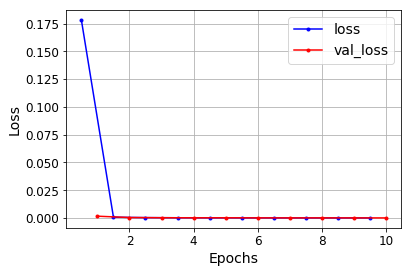

In [764]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="val_loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
#     plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history['loss'],history.history['val_loss'])


Looks like this model actually overfits quite quickly. But based on Recall, it seems ot be handling the minority class okay.

In [773]:
# ?test_masking_model.evaluate
# print('Evaluating...')
scores = model.evaluate(X_val[:,:,:], y_val[:,:,:])
# # print("Metrics: accuracy, binary_crossentropy, Precision, Recall: ",scores)

39651/39651 [==============================] - 33s 842us/sample - loss: 7.7223e-05 - accuracy: 0.9999 - binary_crossentropy: 7.7710e-04 - Precision: 1.0000 - Recall: 0.9903


In [766]:

y_pred = model.predict_classes(X_val[:,:,:])
y_actual = y_val[:,:,:]
print('y_pred: {} y_actual: {}'.format(y_pred.shape, y_actual.shape))
print(classification_report(tf.reshape(y_actual,[-1]), tf.reshape(y_pred,[-1])))


y_pred: (39651, 26, 1) y_actual: (39651, 26, 1)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1030514
           1       1.00      0.99      1.00       412

    accuracy                           1.00   1030926
   macro avg       1.00      1.00      1.00   1030926
weighted avg       1.00      1.00      1.00   1030926



## Test the LSTM on ecommerce sequence

In [767]:
y_pred = model.predict_classes(X_test[:,:,:])
y_actual = y_test[:,:,:]

print('y_pred: {} y_actual: {}'.format(y_pred.shape, y_actual.shape))
print(classification_report(tf.reshape(y_actual,[-1]), tf.reshape(y_pred,[-1])))


y_pred: (67973, 26, 1) y_actual: (67973, 26, 1)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1766548
           1       0.98      0.99      0.99       750

    accuracy                           1.00   1767298
   macro avg       0.99      1.00      0.99   1767298
weighted avg       1.00      1.00      1.00   1767298



# Conclusion

## XGBoost Classifier

Using XGBoost immediately produced a model that had improved performance when compared to the Logistic Regression and Random Forest. The baseline XGBoost model had high precision, but the recall was low.  

Since the original dataset was very imbalanced, we used SMOTE resampling to produce a dataset which would allow the model to more effectively understand conversions. After being trained on the resampled data and using gridsearch to optimize the parameters,  the XGBoost performance was improved significantly from the original baseline. There is still an opportunity to improve the model further by conducting a more through gridsearch, and over more folds. Overall, XGBoost produced a high performing model. 

## LSTM:

Why LSTM? 

We'd already approached the problem one way: with a dataset that didn't have any clear link between the past behaviour of a custoemr and future behaviour. We wanted to try using sequential data instead. Customer behaviour lends itself pretty well to this, as companies are always trying to predict customer journeys.

This was a real learning experience! We were working with a massive dataset that eventually had to be trimmed. It was also highly imbalanced, and due to the peculiar nature of the dataset, it was hard to resample. Our positive and negative classes were not divided up between customers, but between timesteps, so each customer could potentially have a mix of classes. 

In the baseline LSTM, without any tuning, there was an immediate problem with Recall, becasue it could not manage to learn the pattern of the very small sample of positive classes. 

So our approach was to regularize our model. We used Adam Optimizer, Dropout layers, normalization layer, and both a learning rate scheduler and an adjuster for Learning rate on plateau. We hoped that this would mitigate the imbalanced class problem, and it took a few tries tuning the model before Recall improved. This notebook only contains the final code used. Happily for us, eventually the model improved, and we finally ran it on the test set.